# Detrended Fluctuation Analysis

The DFA measure 'a', _should_ relate to the power spectrum exponent (f^-b) as:
- `b = 2a - 1` or
- `a = (b + 1) / 2`

Note that (from quick checks) this appears to be true in the range of `b` from -3 to 0. 
- It seems like it breaks down with exponent of less than -3
- It also doesn't seem to hold for exponents > 0

In [246]:
from neurodsp.sim import *

from neurodsp.spectral import compute_spectrum

In [234]:
from fooof.plts import plot_spectra

## Settings

In [314]:
# General simulation settings
n_seconds = 10
fs = 1000

## Aperiodic: Power Law

In [315]:
# Specific settings
exp = -2

In [316]:
sig_pl = sim_powerlaw(n_seconds, fs, exp)

In [317]:
scales, dfs, alpha = dfa(sig_pl, fs)

In [318]:
print('Measured Alpha:\t {:1.4f}'.format(alpha))
print('Expected Alpha:\t {:1.4f}'.format((-exp + 1) / 2))

Measured Alpha:	 1.4350
Expected Alpha:	 1.5000


## Aperiodic: Power Law Signal with a knee

In [319]:
# Expected exp
exp_kn = -2

In [320]:
sig_kn = sim_synaptic_current(n_seconds, fs)

In [321]:
scales, dfs, alpha = dfa(sig_kn, fs)

In [322]:
print('Measured Alpha:\t {:1.4f}'.format(alpha))
print('Expected Alpha:\t {:1.4f}'.format((-exp_kn + 1) / 2))

Measured Alpha:	 0.8834
Expected Alpha:	 1.5000


In [323]:
f1, p1 = compute_spectrum(sig_pl, fs)
f2, p2 = compute_spectrum(sig_kn, fs)

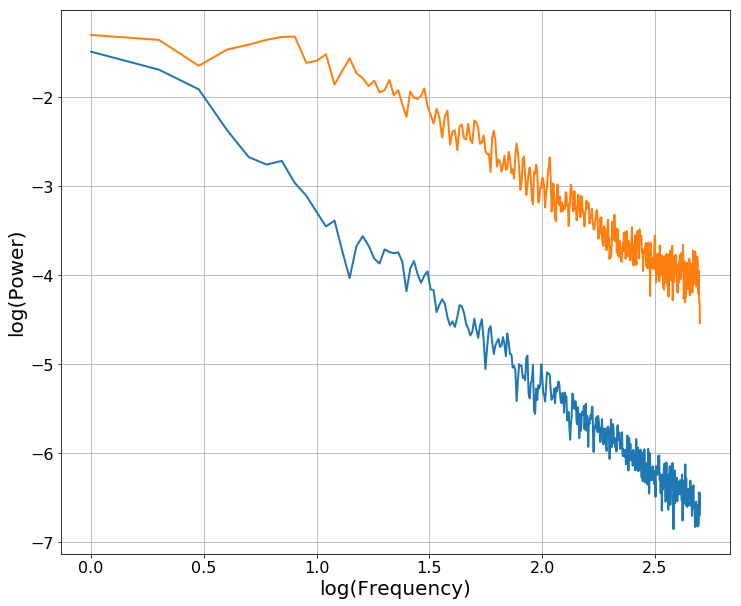

In [325]:
plot_spectra([f1, f2], [p1, p2], True, True)

## Power Law Signal with a knee

In [213]:
# Copied from rdgao SpaceRecon / nlds

import numpy as np
import scipy as sp

def dfa(data, fs, n_scales=10, min_scale=0.01, max_scale=1.0, deg=1, method='dfa'):
    """ Perform Detrended Fluctuation Analysis (DFA) on a given time series by
    dividing the data into non-overlapping windows at log-spaced scales and
    computing the mean RMS of fits over all window at each scale.
    Parameters
    ----------
    data : array, 1-D
        Data to compute DFA over.
    fs : float, Hz
        Sampling frequency of data.
    n_scales : int (default=10)
        Number of scales to estimate fluctuations over.
    min_scale : float, seconds (default=0.01s)
        Shortest scale to compute DFA over.
    max_scale : float, seconds (default=1.0s)
        Longest scale to compute DFA over.
    deg : int (default=1)
        Polynomial degree for detrending. 1 for regular DFA, 2 or higher for
        generalized DFA.
    method : str (default='dfa')
        Method to compute per-window fluctuation.
        'dfa' : detrended fluctuation (OLS fit of data window). Empirically, DFA
            seems to work for a larger range of exponent values.
        'rs' : rescaled range (range divided by std)
    Returns
    -------
    t_scales : array, 1-D
        Time-scales over which detrended fluctuations was performedself.
    DFs : array, 1-D
        Mean RMS (fluctuations) at each scale.
    alpha : float
        Slope of line in loglog when plotting t_scales against DFs (Hurst exp.).
    """
    # get log10 equi-spaced scales and translate that into window lengths
    t_scales = np.logspace(np.log10(min_scale), np.log10(max_scale), n_scales)
    win_lens = np.round(t_scales * fs).astype('int')
    # get culmulative sum
    data_walk = sp.cumsum(data - np.mean(data))
    DFs = np.zeros_like(t_scales)
    # step through each scale and get RMS
    for idx, win_len in enumerate(win_lens):
        if method is 'dfa':
            DFs[idx] = compute_DF(data_walk, win_len=win_len, deg=deg)
        elif method is 'rs':
            DFs[idx] = compute_RS(data_walk, win_len=win_len)

    # get DFA exponent
    alpha = np.polyfit(np.log10(t_scales), np.log10(DFs), deg=1)[0]
    return t_scales, DFs, alpha

def compute_RS(data, win_len):
    """Compute rescaled range of a given time-series at a given scale.
    Parameters
    ----------
    data : array, 1-D
        Data to compute R/S over.
    win_len : int
        Window length for each R/S computation.
    Returns
    -------
    x : float
        Mean R/S over all sub-windows of data.
    """
    # gather all windows
    n_win = int(np.floor(len(data) / win_len))
    # vectorize the data so we can call math functions in one go
    Z_rect = np.reshape(data[:n_win * win_len], (n_win, win_len)).T
    # get back the data by taking the derivative of data_walk
    X = np.concatenate((data[:1],np.diff(data)))
    X_rect = np.reshape(X[:n_win * win_len], (n_win, win_len)).T

    RS_seg = np.ptp(Z_rect, axis=0)/np.std(X_rect, axis=0)
    return np.mean(RS_seg)


def compute_DF(data, win_len, deg=1):
    """ Compute detrended fluctuation of the data at the given window length.
    Parameters
    ----------
    data : array, 1-D
        Data to compute DFA over.
    win_len : int
        Window length for each DF fit.
    deg : int (default=1)
        Polynomial degree for detrending.
    Returns
    -------
    x : float
        mean RMS across fits.
    """
    # gather all windows
    n_win = int(np.floor(len(data) / win_len))
    # vectorize the data so we can call np.polyfit in one go
    data_rect = np.reshape(data[:n_win * win_len], (n_win, win_len)).T
    # fitting
    coef, fluc, _, _, _ = np.polyfit(
        np.arange(win_len), data_rect, deg=deg, full=True)
    # fluc cntains sum of squared error, we want mean RMS across fits
    return np.mean((fluc / win_len)**0.5)